# Project 3 - Subreddit Classification
### by Steven Tran

| **Notebooks** |
|-----------|
|[01_Data_Collection](01_Data_Collection.ipynb)|
|[02_Cleaning_and_EDA.ipynb](02_Cleaning_and_EDA.ipynb)|
|[03_Preprocessing_Modeling_and_Tuning](03_Preprocessing_Modeling_and_Tuning.ipynb)|
|[04_Production_Model_and_Conclusion](04_Production_Model_and_Conclusion.ipynb)|

---

# 02: Cleaning and EDA


In [1]:
# imports:
import pandas as pd, numpy as np, matplotlib.pyplot as plt, seaborn as sns
from nltk.tokenize import sent_tokenize, word_tokenize, RegexpTokenizer

# using this option from lesson 5.05 modeling with VADER to display more text in columns:
pd.options.display.max_colwidth = 200

#read in data:
unpop = pd.read_csv('../data/posts__unpopular_opinion.csv')
rants = pd.read_csv('../data/posts__rants.csv')

---

### Clean up `title` and `selftext`

To consistently clean the `title` and `selftext` fields in each of our subreddits, I'll define a function to accomplish the following in the cell below:

1. Remove any urls (using regex replace patter seen in **lesson 5.05-modeling-with-vader**
1. Remove newlines `\n`, special quotes `chr(8220) and chr(8221)`, and zero-width space characters `#x200B`
     * method inspired by [this stackoverflow answer](https://stackoverflow.com/a/1919112)
1. Trim any leading or trailing whitespace using `.strip()`
1. Remove NAs `df.dropna(inplace=True)`. There could be new NAs resulting from the steps above.
1. Remove any observations where the text string length has been reduced to 0

In [2]:
def clean_text(df, series):
    #dictionary for string replacement inspired by this stackoverflow answer: https://stackoverflow.com/a/1919112

    replacements = {'\n': '',
                    chr(8220): chr(34),
                    chr(8221): chr(34),
                    '#x200B;': ' '}
    
    #do replacements, url regex replacement first:
    df.loc[:,series] = df[series].replace('http\S+', '', regex=True).replace('www\S+', '', regex=True)
    #then patterns defined in dict above:
    for k, v in replacements.items():
        df.loc[:,series] = df[series].str.replace(k,v)
    
    #strip whitespace:    
    df.loc[:,series] = df[series].str.strip()
    
    #drop nulls
    df.drop(df[df[series].isna()].index,inplace=True)
    
    #drop 0 length strings:
    df.drop(df[df[series].apply(len)==0].index,inplace=True)
    
    #reset indices:
    df.reset_index(drop=True,inplace=True)


In [3]:
dataframes = {'unpopular_opinion': unpop,
              'rants': rants}

columns = ['title','selftext']

for dataframe in dataframes:
    for column in columns:
        clean_text(dataframes.get(dataframe),column)

In [4]:
# see now how many rows are left in each DF:
for dataframe in dataframes:
    print(f'{dataframe}: {dataframes.get(dataframe).shape[0]} rows.')

unpopular_opinion: 8000 rows.
rants: 7715 rows.


---

### Reformat dates

Will convert the `created_utc` to a datetime. Method inspired by this [webpost](https://pythonguides.com/python-epoch-to-datetime/).

In [5]:
#convert utc int to datetime:
import datetime
for dataframe in dataframes:
    dataframes.get(dataframe)['created_utc'] = [datetime.datetime.fromtimestamp(utc).strftime('%Y-%m-%d %H:%M:%S') for utc in dataframes.get(dataframe)['created_utc']]


---

# EDA

For EDA, I'd like to accomplish the following for each subreddit:
* Get mean `title` and `selftext` word count.
* Get mean `title` and `selftext` string length.
* Get mean **ratio** of `title`:`selftext` word count.
* Get mean **ratio** of `title`:`selftext` string length.
* Get the top words observed in each subreddit.

In [6]:
title_text_stats = {}

for dataframe in dataframes:
    df = dataframes.get(dataframe)
    #get wordlengths:
    df['title_wordlen'] = df['title'].map(lambda x: len(x.split(' ')))
    df['text_wordlen'] = df['selftext'].map(lambda x: len(x.split(' ')))
      #ratio:
    df['wordlen_ratio'] = df['title_wordlen']/df['text_wordlen']
    #get stringlengths
    df['title_strlen'] = df['title'].apply(len)
    df['text_strlen'] = df['selftext'].apply(len)
      #ratio:
    df['strlen_ratio'] = df['title_strlen']/df['text_strlen']
    
    title_text_stats[dataframe] = {
        'mean_title_wordlen': df['title_wordlen'].mean(),
        'mean_title_strlen': df['title_strlen'].mean(),
        'mean_text_wordlen': df['text_wordlen'].mean(),
        'mean_text_strlen': df['text_strlen'].mean(),
        'mean_wordlen_ratio':df['wordlen_ratio'].mean(),
        'mean_strlen_ratio':df['strlen_ratio'].mean(),
        'count_posts': int(df.shape[0]),
    }

In [7]:
title_text_stats = pd.DataFrame.from_dict(title_text_stats).T
title_text_stats.T

,unpopular_opinion,rants
mean_title_wordlen,10.979750,10.067401
mean_title_strlen,62.614875,54.851977
mean_text_wordlen,117.397500,185.042255
mean_text_strlen,646.520000,988.884381
mean_wordlen_ratio,0.147944,0.219994
mean_strlen_ratio,0.166634,0.242519
count_posts,8000.000000,7715.000000


---

## Plotting

Declare some global plotting variables:

In [8]:
my_figsize = (12, 4)

## Plot `title` stats:

* Word counts:

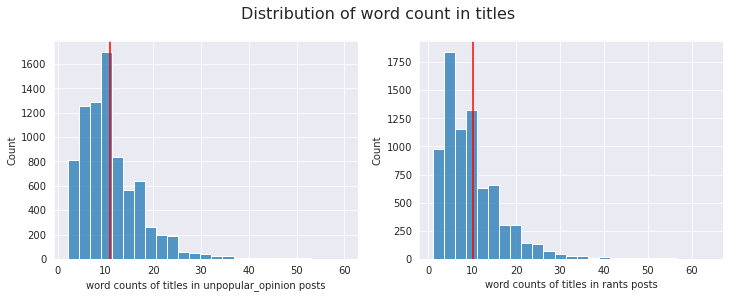

In [9]:
with sns.axes_style("darkgrid"):
    fig, axs = plt.subplots(1,2,figsize=my_figsize)
    fig.suptitle('Distribution of word count in titles', y = 1, fontsize=16)
    for i, dataframe in enumerate(dataframes):
        df = dataframes.get(dataframe)

        #axs[] indexer needs to be [0,1,2] comma [0,1] for 3 row x 2 col subplot grid
        sns.histplot(x=df['title_wordlen'], bins=25,ax=axs[i])
        axs[i].axvline(x=title_text_stats.loc[dataframe,'mean_title_wordlen'], color = 'red')
        axs[i].set(xlabel=f'word counts of titles in {dataframe} posts')
        axs[i].tick_params(labelbottom=True)

* String lengths:

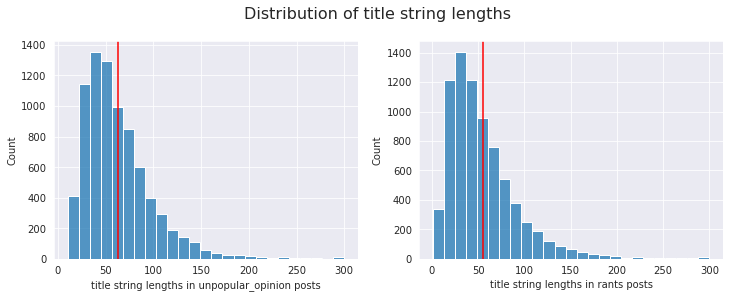

In [10]:
with sns.axes_style("darkgrid"):
    fig, axs = plt.subplots(1,2,figsize=my_figsize)
    fig.suptitle('Distribution of title string lengths', y = 1, fontsize=16)
    for i, dataframe in enumerate(dataframes):
        df = dataframes.get(dataframe)

        #axs[] indexer needs to be [0,1,2] comma [0,1] for 3 row x 2 col subplot grid
        sns.histplot(x=df['title_strlen'], bins=25,ax=axs[i])
        axs[i].axvline(x=title_text_stats.loc[dataframe,'mean_title_strlen'], color = 'red')
        axs[i].set(xlabel=f'title string lengths in {dataframe} posts')
        axs[i].tick_params(labelbottom=True)

## Plot `selftext` stats:

* Word counts:

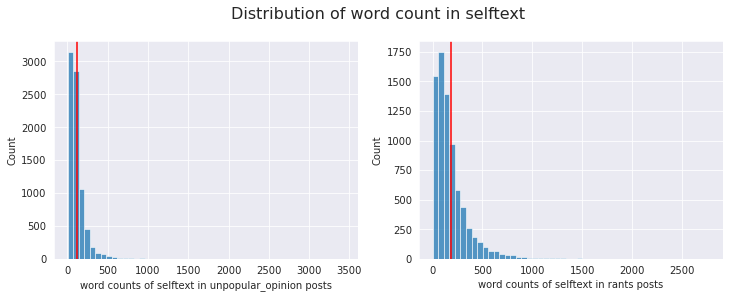

In [11]:
with sns.axes_style("darkgrid"):
    fig, axs = plt.subplots(1,2,figsize=my_figsize)
    fig.suptitle('Distribution of word count in selftext', y = 1, fontsize=16)
    for i, dataframe in enumerate(dataframes):
        df = dataframes.get(dataframe)

        #axs[] indexer needs to be [0,1,2] comma [0,1] for 3 row x 2 col subplot grid
        sns.histplot(x=df['text_wordlen'], bins=50,ax=axs[i])
        axs[i].axvline(x=title_text_stats.loc[dataframe,'mean_text_wordlen'], color = 'red')
        axs[i].set(xlabel=f'word counts of selftext in {dataframe} posts')
        axs[i].tick_params(labelbottom=True)

* String lengths:

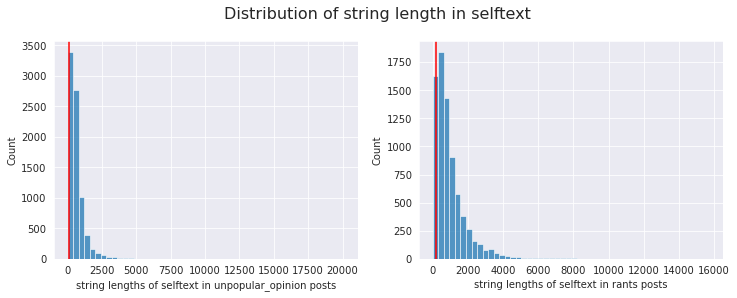

In [12]:
with sns.axes_style("darkgrid"):
    fig, axs = plt.subplots(1,2,figsize=my_figsize)
    fig.suptitle('Distribution of string length in selftext', y = 1, fontsize=16)
    for i, dataframe in enumerate(dataframes):
        df = dataframes.get(dataframe)

        #axs[] indexer needs to be [0,1,2] comma [0,1] for 3 row x 2 col subplot grid
        sns.histplot(x=df['text_strlen'], bins=50,ax=axs[i])
        axs[i].axvline(x=title_text_stats.loc[dataframe,'mean_text_wordlen'], color = 'red')
        axs[i].set(xlabel=f'string lengths of selftext in {dataframe} posts')
        axs[i].tick_params(labelbottom=True)

## Plot `ratios`:

* Word counts:

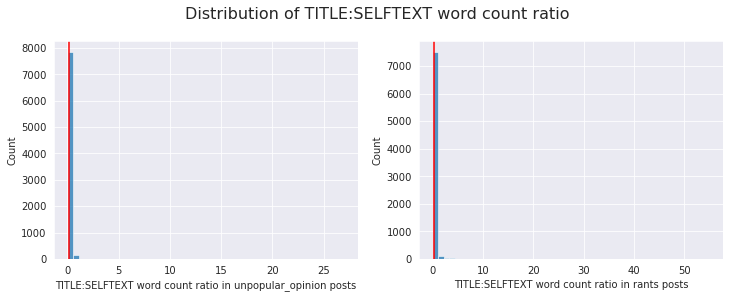

In [13]:
with sns.axes_style("darkgrid"):
    fig, axs = plt.subplots(1,2,figsize=my_figsize)
    fig.suptitle('Distribution of TITLE:SELFTEXT word count ratio', y = 1, fontsize=16)
    for i, dataframe in enumerate(dataframes):
        df = dataframes.get(dataframe)

        #axs[] indexer needs to be [0,1,2] comma [0,1] for 3 row x 2 col subplot grid
        sns.histplot(x=df['wordlen_ratio'], bins=50,ax=axs[i])
        axs[i].axvline(x=title_text_stats.loc[dataframe,'mean_wordlen_ratio'], color = 'red')
        axs[i].set(xlabel=f'TITLE:SELFTEXT word count ratio in {dataframe} posts')
        axs[i].tick_params(labelbottom=True)

* String lengths:

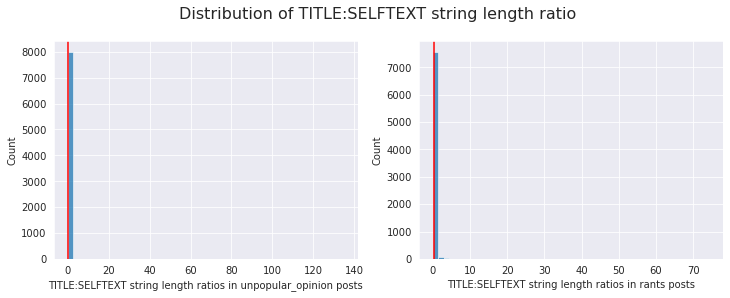

In [14]:
with sns.axes_style("darkgrid"):
    fig, axs = plt.subplots(1,2,figsize=my_figsize)
    fig.suptitle('Distribution of TITLE:SELFTEXT string length ratio', y = 1, fontsize=16)
    for i, dataframe in enumerate(dataframes):
        df = dataframes.get(dataframe)

        #axs[] indexer needs to be [0,1,2] comma [0,1] for 3 row x 2 col subplot grid
        sns.histplot(x=df['strlen_ratio'], bins=50,ax=axs[i])
        axs[i].axvline(x=title_text_stats.loc[dataframe,'mean_strlen_ratio'], color = 'red')
        axs[i].set(xlabel=f'TITLE:SELFTEXT string length ratios in {dataframe} posts')
        axs[i].tick_params(labelbottom=True)

---

## Checking sentiments

I want to know if the tone of specific wordage used has any impact on whether it belongs in one subreddit or the other. To do this, we'll use the Valence Aware Dictionary and sEntiment Reasoner or VADER. This section largely inspired by **lesson 5.05-modeling-with-vader**. 

However, first we'll need to preprocess the `title` and `selftext` fields to tokenize and stem the words to reduce variations of common words. This part inspired by **lesson 5.04-NLP-I**.


**Section Objectives**
* Create `title_lemma` and `selftext_lemma` fields for the dataset.
* Create `title_comp_sent` and `selftext_comp_sent` fields for the dataset.

### Lemmatizing:
* Create `title_lemma` and `selftext_lemma` fields for the dataset.

In [15]:
from nltk.tokenize import RegexpTokenizer
from nltk.stem import WordNetLemmatizer

In [16]:
tokenizer = RegexpTokenizer('\s+', gaps=True)
lemmatizer = WordNetLemmatizer()

In [17]:
for dataframe in dataframes:
    df = dataframes.get(dataframe)
    #first, deal with titles:
    tokens = [tokenizer.tokenize(i) for i in df['title']]
    lemma = [[lemmatizer.lemmatize(x.lower()) for x in i] for i in tokens]
    df['title_lemma'] = [' '.join(i) for i in lemma] 
    
    #then deal with selftext:
    tokens = [tokenizer.tokenize(i) for i in df['selftext']]
    lemma = [[lemmatizer.lemmatize(x.lower()) for x in i] for i in tokens]
    df['selftext_lemma'] = [' '.join(i) for i in lemma] 


### Sentiment Analysis:
* Create `title_comp_sent` and `selftext_comp_sent` fields for the dataset.

We are using VADER to determine the compound sentiment score for the words used in the `title` and the `selftext` fields.

In [18]:
from nltk.sentiment.vader import SentimentIntensityAnalyzer
#instantiate
sia = SentimentIntensityAnalyzer()

In [19]:
for dataframe in dataframes:
    df = dataframes.get(dataframe)
    
    #get title's compound sentiment:
    sentiment = []
    corpus = list(df['title_lemma'])
    for text in corpus:
        scores = sia.polarity_scores(text)
        sentiment.append(scores['compound'])
    df['title_comp_sent'] = sentiment
    
    #get selftext's compound sentiment:
    sentiment = []
    corpus = list(df['selftext_lemma'])
    for text in corpus:
        scores = sia.polarity_scores(text)
        sentiment.append(scores['compound'])
    df['selftext_comp_sent'] = sentiment

---
#### Compound Sentiment in Titles

In [46]:
title_comp_sent = pd.concat([unpop[['subreddit','title_comp_sent']],rants[['subreddit','title_comp_sent']]],axis=0,ignore_index=True)

In [51]:
title_comp_sent.groupby('subreddit')['title_comp_sent'].mean()

subreddit
rant               -0.199908
unpopularopinion   -0.025918
Name: title_comp_sent, dtype: float64

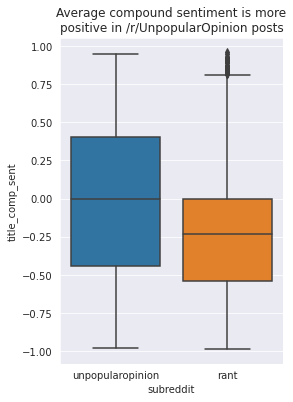

In [72]:
with sns.axes_style("darkgrid"):
    plt.figure(figsize=(4,6))
    plt.title('Average compound sentiment is more\npositive in /r/UnpopularOpinion posts')
    sns.boxplot(x=title_comp_sent['subreddit'], y=title_comp_sent['title_comp_sent']);

---
#### Compound Sentiment in Selftext

In [62]:
sf_comp_sent = pd.concat([unpop[['subreddit','selftext_comp_sent']],rants[['subreddit','selftext_comp_sent']]],axis=0,ignore_index=True)

In [63]:
sf_comp_sent.groupby('subreddit')['selftext_comp_sent'].mean()

subreddit
rant               -0.251110
unpopularopinion    0.157979
Name: selftext_comp_sent, dtype: float64

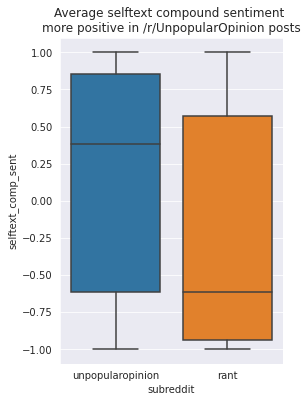

In [69]:
with sns.axes_style("darkgrid"):
    plt.figure(figsize=(4,6))
    plt.title('Average selftext compound sentiment \nmore positive in /r/UnpopularOpinion posts')
    sns.boxplot(x=sf_comp_sent['subreddit'], y=sf_comp_sent['selftext_comp_sent']);

---

## Top Words by Subreddit

To get the top words, I'll be using `CountVectorizer`. Whether we'll use it for modeling will be determined in a later step.

In [20]:
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction import text

In [79]:
custom_stopwords = ['fuck','mad', 'really','fucking','just','like','know', 'unpopular', 'opinion', 'evil', 'ody','ama','hoes','chrome','filler', 'orange', 'green', 'yellow', 'canker']
stopwords = text.ENGLISH_STOP_WORDS.union(custom_stopwords)

### Unigrams

In [22]:
cvec = CountVectorizer(stop_words=stopwords,ngram_range=(1,1),max_features=1000)
unpop_words = unpop['title'] + ' ' + unpop['selftext']
rants_words = rants['title'] + ' ' + rants['selftext']

unpop_cvec = cvec.fit_transform(unpop_words)
u_cvec_df = pd.DataFrame(unpop_cvec.todense(), columns = cvec.get_feature_names())
rants_cvec = cvec.fit_transform(rants_words)
r_cvec_df = pd.DataFrame(rants_cvec.todense(),columns = cvec.get_feature_names())

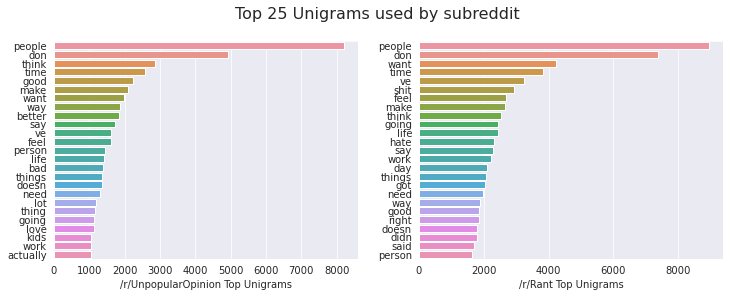

In [23]:
with sns.axes_style("darkgrid"):
    fig, axs = plt.subplots(1,2,figsize=my_figsize)
    fig.suptitle('Top 25 Unigrams used by subreddit', y = 1, fontsize=16)
    for i, dataframe in enumerate([u_cvec_df, r_cvec_df]):
        df = dataframe
        dfx = df.sum().sort_values(ascending=False).head(25)
        dfy = df.sum().sort_values(ascending=False).head(25).index
        #axs[] indexer needs to be [0,1,2] comma [0,1] for 3 row x 2 col subplot grid
        sns.barplot(y=dfy,x=dfx,orient='h',ax=axs[i])
    
    
    axs[0].set(xlabel=f'/r/UnpopularOpinion Top Unigrams')
    axs[1].set(xlabel=f'/r/Rant Top Unigrams')

### Bigrams

In [24]:
cvec = CountVectorizer(stop_words=stopwords,ngram_range=(2,2),max_features=1000)
unpop_words = unpop['title'] + ' ' + unpop['selftext']
rants_words = rants['title'] + ' ' + rants['selftext']

unpop_cvec = cvec.fit_transform(unpop_words)
u_cvec_df = pd.DataFrame(unpop_cvec.todense(), columns = cvec.get_feature_names())
rants_cvec = cvec.fit_transform(rants_words)
r_cvec_df = pd.DataFrame(rants_cvec.todense(),columns = cvec.get_feature_names())

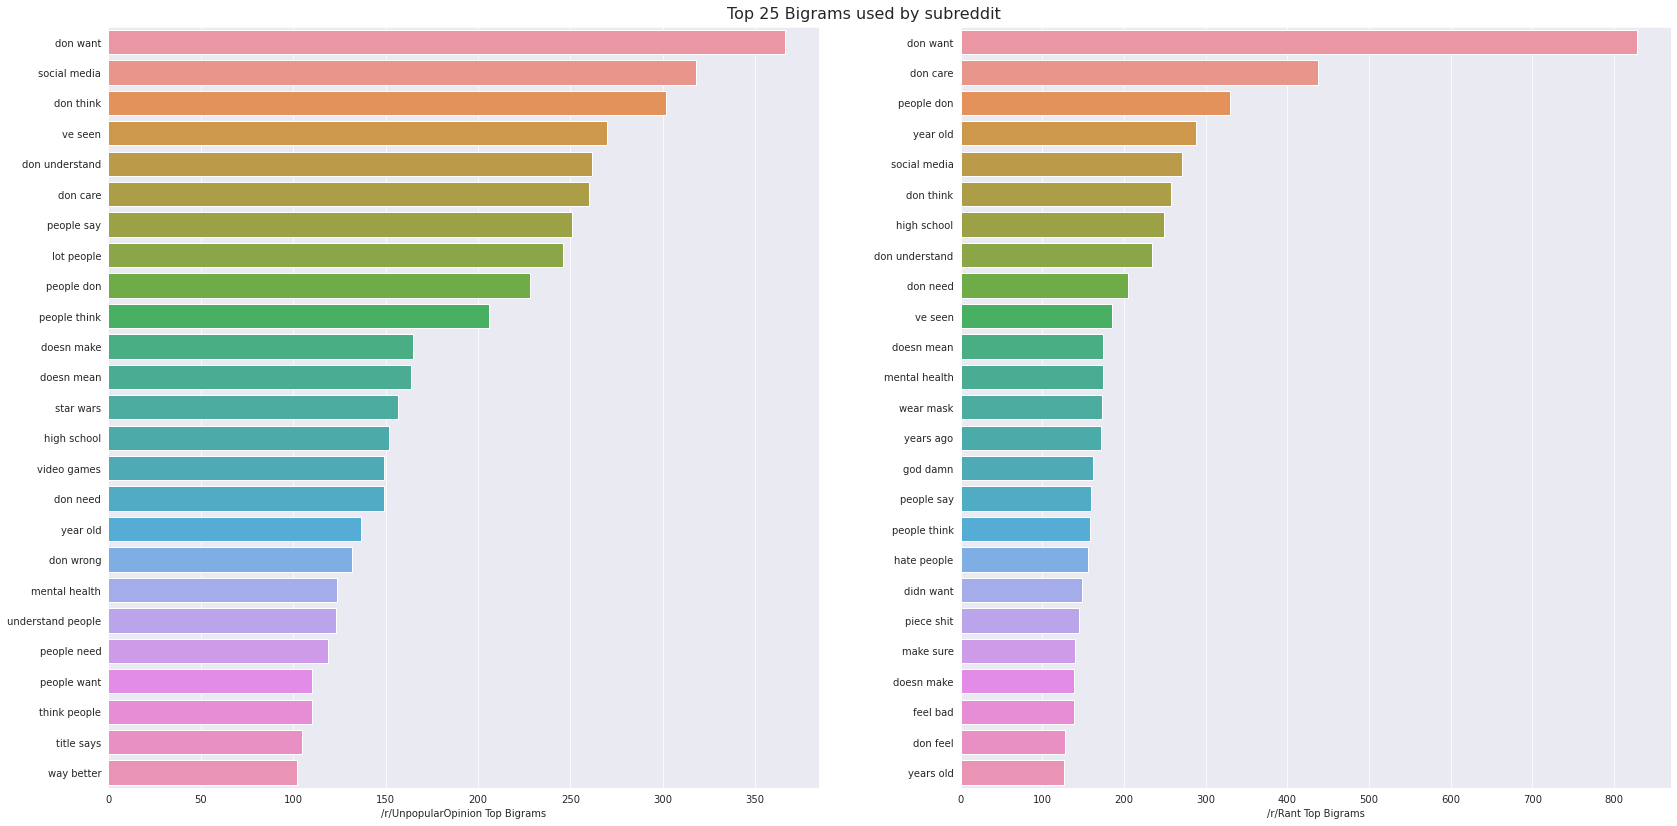

In [25]:
with sns.axes_style("darkgrid"):
    fig, axs = plt.subplots(1,2,figsize=(28,14))
    fig.suptitle('Top 25 Bigrams used by subreddit', y = .9, fontsize=16)
    for i, dataframe in enumerate([u_cvec_df, r_cvec_df]):
        df = dataframe
        dfx = df.sum().sort_values(ascending=False).head(25)
        dfy = df.sum().sort_values(ascending=False).head(25).index
        #axs[] indexer needs to be [0,1,2] comma [0,1] for 3 row x 2 col subplot grid
        sns.barplot(y=dfy,x=dfx,orient='h',ax=axs[i])
    
    
    axs[0].set(xlabel=f'/r/UnpopularOpinion Top Bigrams')
    axs[1].set(xlabel=f'/r/Rant Top Bigrams')

### Trigrams

In [80]:
cvec = CountVectorizer(stop_words=stopwords,ngram_range=(3,3),max_features=1000)
unpop_words = unpop['title'] + ' ' + unpop['selftext']
rants_words = rants['title'] + ' ' + rants['selftext']

unpop_cvec = cvec.fit_transform(unpop_words)
u_cvec_df = pd.DataFrame(unpop_cvec.todense(), columns = cvec.get_feature_names())
rants_cvec = cvec.fit_transform(rants_words)
r_cvec_df = pd.DataFrame(rants_cvec.todense(),columns = cvec.get_feature_names())

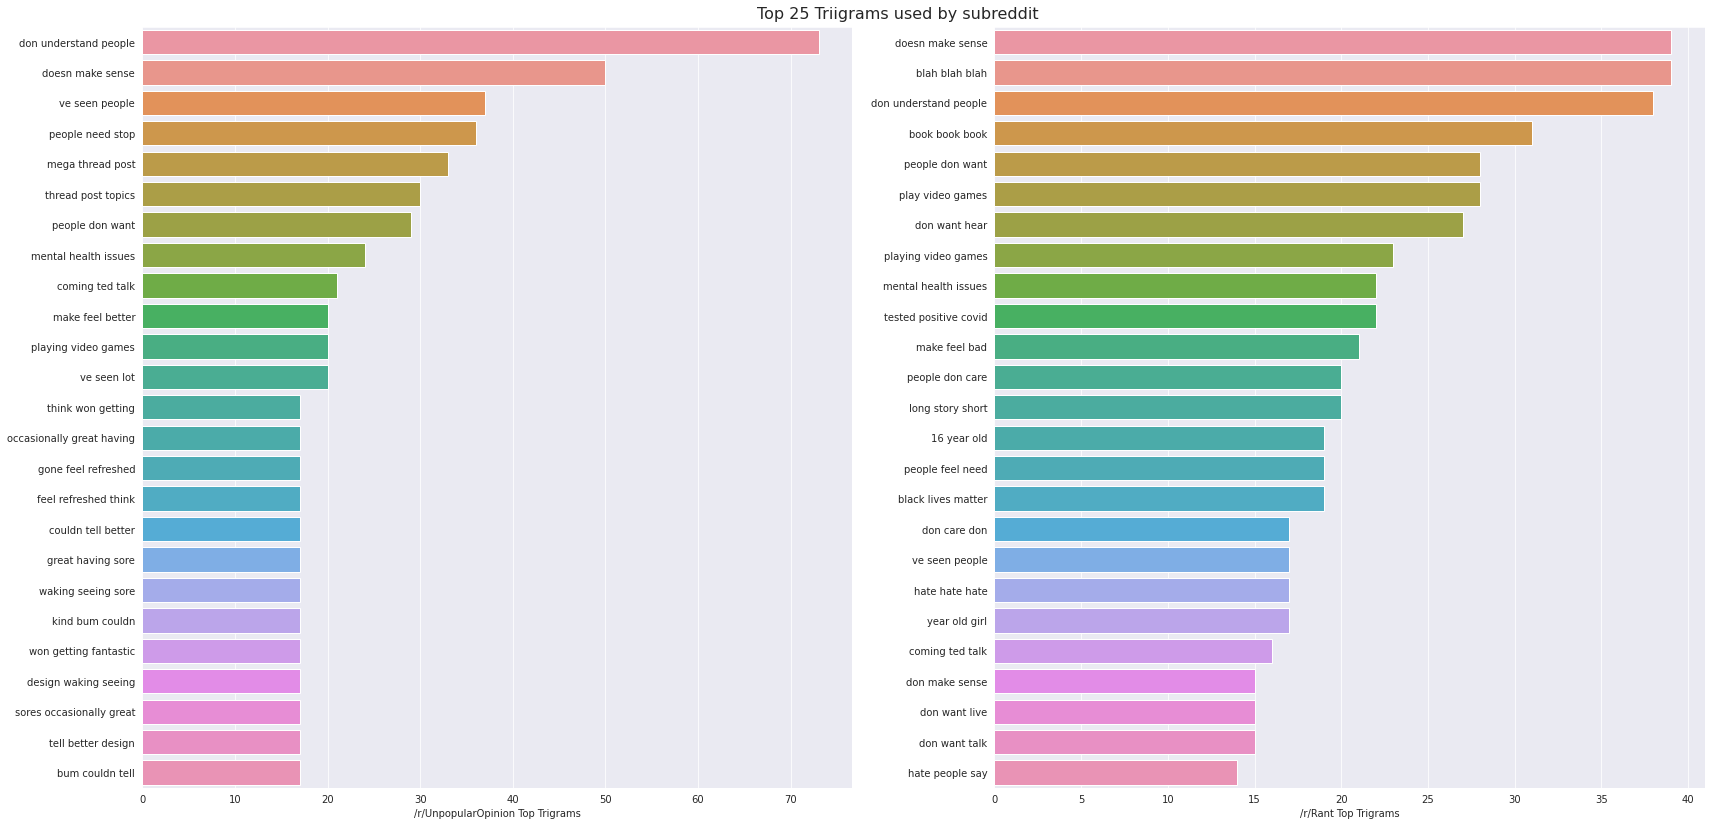

In [81]:
with sns.axes_style("darkgrid"):
    fig, axs = plt.subplots(1,2,figsize=(28,14))
    fig.suptitle('Top 25 Triigrams used by subreddit', y = .9, fontsize=16)
    for i, dataframe in enumerate([u_cvec_df, r_cvec_df]):
        df = dataframe
        dfx = df.sum().sort_values(ascending=False).head(25)
        dfy = df.sum().sort_values(ascending=False).head(25).index
        #axs[] indexer needs to be [0,1,2] comma [0,1] for 3 row x 2 col subplot grid
        sns.barplot(y=dfy,x=dfx,orient='h',ax=axs[i])
    
    
    axs[0].set(xlabel=f'/r/UnpopularOpinion Top Trigrams')
    axs[1].set(xlabel=f'/r/Rant Top Trigrams')

---

# Create combined dataframe


In [28]:
controversial = pd.concat([unpop,rants],ignore_index=True)
#Binarize classification targets
controversial.loc[:,'subreddit'] = controversial['subreddit'].map({'unpopularopinion': 1, 'rant': 0})
#Update dataframes variable for the rest of EDA:
dataframes = {'unpopularopinions': controversial}

---

## Some correlation plots:

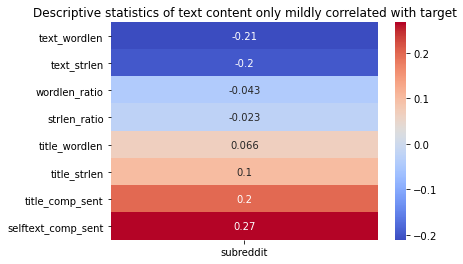

In [29]:
plt.title('Descriptive statistics of text content only mildly correlated with target')
sns.heatmap(controversial.corr()[['subreddit']].sort_values('subreddit')[:-1],annot=True,cmap='coolwarm');

The results of this correlation plots tells me that word count and string length in the post text is not a very strong indicator of whether the post belongs in one subreddit or the other. The ratios for word count and string length in titles and selftexts does not appear to be significant either. 

This probably suggests that the specific words that tend to appear or be absent from `title` and `selftext` are better predictors of the `subreddit`.

We are dealing with potentially many words in our dataframe's `title` and `selftext` fields. We'll probably need to be selective about which ones are important to use and which we exclude in modeling. To accomplish this, we'll need to determine which vectorization method to use -- `CountVectorizer` or `TfidfVectorizer`.

---

## Choosing between `CountVectorizer` or `TfidfVectorizer`

Which model will be the best at classifying whether a post is from Subreddit A or Subreddit B is still to be determined, but I'd like to use Logistic Regression to help us determine which text vectorizer to use: `CountVectorizer` or `TfidfVectorizer`.

The contest will be simple. Construct two logistic regression pipelines, one using `CountVectorizer` and one using `TfidfVectorizer`, and assessing the accuracy resulting from each untuned vectorizer. I'll do this both for the lemmatized `title` and `selftext` fields. The one with the higher average accuracy will be the vectorizer we use for modeling in [03_Preprocessing_Modeling_and_Tuning](03_Preprocessing_Modeling_and_Tuning.ipynb).

Some constraints:
* `CountVectorizer`:
    * `max_features` must be 3,000
    * Must exclude English `stop_words` 
* `LogisticRegression()`:
    * `max_iter` must be 5000  

Let's start:

In [30]:
from sklearn.feature_extraction.text import TfidfVectorizer #CountVectorizer already imported
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

#instantiate a scorekeeper:
scores = {}

In [31]:
for dataframe in dataframes:
    df = dataframes.get(dataframe)
    scores[dataframe] = {}
    for column in ['title_lemma','selftext_lemma']:
        #set up X and y:
        X = df[column]
        y = df['subreddit']

        #train/test split:
        X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=.2,stratify=y,random_state=42)

        #set up pipes:
        cvec_pipe = Pipeline([
            ('cvec', CountVectorizer(stop_words = 'english',max_features=3_000)),
            ('cv_logreg', LogisticRegression(max_iter=5000))
        ])

        tfidf_pipe = Pipeline([
            ('tfidf', TfidfVectorizer(stop_words= 'english',max_features=3_000)),
            ('tfidf_logreg', LogisticRegression(max_iter=5000))
        ])

        #fit the pipelines
        cvec_pipe.fit(X_train,y_train)
        tfidf_pipe.fit(X_train,y_train)    

        scores[dataframe]['cvec_' + column] = cvec_pipe.score(X_test,y_test)
        scores[dataframe]['tfidf_' + column] = tfidf_pipe.score(X_test,y_test)

In [32]:
evaluate = pd.DataFrame(scores).T
evaluate['cvec_avg'] = (evaluate['cvec_title_lemma']+evaluate['cvec_selftext_lemma'])/2
evaluate['tfidf_avg'] = (evaluate['tfidf_title_lemma'] + evaluate['tfidf_selftext_lemma'])/2
evaluate[['cvec_avg', 'tfidf_avg']]

,cvec_avg,tfidf_avg
unpopularopinions,0.768851,0.786669


### Conclusion on `CountVectorizer` vs. `TfidfVectorizer`

From the results above we can likely conclude the Term Frequency-Inverse Document Frequency vectorizer may be the better (perhaps only marginally) vectorizer and so we'll use it in later modeling.

Further, while `CountVectorizer` would give us regression coefficients which correspond to the effect of **a word being being present or not** in a document, `TfidfVectorizer` will provide us with coefficients which correspond to the effect of *how important* a word is in a document.

---

Save and export cleaned data:



In [33]:
controversial.to_csv('../data/cleaned/unpopularopinions.csv',index=False)